<a href="https://colab.research.google.com/github/mykhailodolitsoi/EDU_pytorch/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural network classification with PyTorch

Classification is a problem of predicting wheter something is one thing or another.

## 1. Make classification data

In [ ]:
import sklearn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch
from torch import nn
import requests
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# make 1000 samples
n_samples = 1000

# create circules
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 0)

print(len(X), len(y),
      f"\n",
      X[:5], y[:5])


1000 1000 
 [[ 0.80993549 -0.053514  ]
 [-0.13448628 -0.74209474]
 [-0.81250606 -0.62424399]
 [ 0.5830736   0.49656776]
 [-0.46132008  0.65983601]] [1 1 0 1 1]


In [ ]:
# make dataFrame
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y[:]})

circles.head(10)

,X1,X2,label
0,0.809935,-0.053514,1
1,-0.134486,-0.742095,1
2,-0.812506,-0.624244,0
3,0.583074,0.496568,1
4,-0.461320,0.659836,1
5,0.738485,-0.263874,1
6,0.925596,0.383517,0
7,-0.984430,0.230591,0
8,-0.818484,-0.686275,0
9,-0.694012,0.390175,1


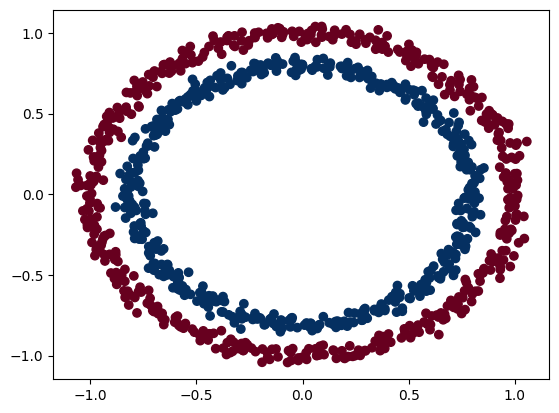

In [ ]:
# visualize
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdBu)

**Note:** The data we are working with is often reffered to as a "toy dataset", a dataset that is small enough to experiment but still sizeable enough to practice the fundamentials

In [ ]:
# input and output shapes
X.shape, y.shape, type(X), type(y)

((1000, 2), (1000,), numpy.ndarray, numpy.ndarray)

In [ ]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

print(X[:5], y[:5])

tensor([[ 0.8099, -0.0535],
        [-0.1345, -0.7421],
        [-0.8125, -0.6242],
        [ 0.5831,  0.4966],
        [-0.4613,  0.6598]]) tensor([1., 1., 0., 1., 1.])


In [ ]:
# split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)


## 2. Building a model

We are going to build a model to classify our blue and red dots.

To do so, we want to:
1. Set up device agnostic code so our code will run on accelerator(GPU).
2. Construct a model(by subclassing `nn.Module`)
3. Define a loss functionand optimizer.
4. Create a training and testing loop.

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# construct a model
class model(nn.Module):
    def __init__(self):
        super().__init__()

        self.in_l = nn.Linear(2, 128)
        self.hi_l_1 = nn.Linear(128, 16)
        self.ou_l = nn.Linear(16, 1)
        self.act_fn = nn.ReLU()

    def forward(self, x):
        return self.ou_l(self.act_fn(self.hi_l_1(self.act_fn(self.in_l(x)))))

model = model()

# model = nn.Sequential(
#     nn.Linear(2, 128),
#     nn.ReLU,
#     nn.Linear(128, 8),
#     nn.ReLU,
#     nn.Linear(8, 1)
# ).to(device)

# setup the loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(),
                         lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Training the model

Our models outputs are going to be raw **logits**.

We can convert these **logits** into **prediction probabilities** by passing them to some kind of activation functioon(e.g. sigmoid for binary classification or softmax for multi-class classification).

Then we can convert our models prediction probabilities to prediction label by either rounding them or the `argmax()`

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epoch_count = []
accs_train = []
accs_test = []

for epoch in range(epochs):
    model.train()

    logits_train = model(X_train).squeeze()
    y_train_pred = torch.round(torch.sigmoid(logits_train))

    loss_train = loss_fn(logits_train, y_train)
    acc_train =  accuracy_fn(y_true=y_train,
                             y_pred=y_train_pred)

    optimizer.zero_grad()

    loss_train.backward()

    optimizer.step()

    model.eval()
    with torch.inference_mode():
        logits_test = model(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(logits_test))

        acc_test = accuracy_fn(y_test, y_test_pred)

    if epoch % 10 == 0:
        epoch_count.append(epoch)
        accs_train.append(acc_train)
        accs_test.append(acc_test)
        print(f"Epoch: {epoch} | Acc_train: {acc_train:.2f}% | Acc_test: {acc_test:.2f}%")


Epoch: 0 | Acc_train: 49.00% | Acc_test: 54.00%
Epoch: 10 | Acc_train: 53.62% | Acc_test: 52.00%
Epoch: 20 | Acc_train: 53.37% | Acc_test: 51.50%
Epoch: 30 | Acc_train: 65.88% | Acc_test: 61.50%
Epoch: 40 | Acc_train: 69.25% | Acc_test: 64.00%
Epoch: 50 | Acc_train: 67.62% | Acc_test: 61.50%
Epoch: 60 | Acc_train: 66.88% | Acc_test: 61.50%
Epoch: 70 | Acc_train: 68.88% | Acc_test: 62.00%
Epoch: 80 | Acc_train: 68.62% | Acc_test: 62.00%
Epoch: 90 | Acc_train: 70.75% | Acc_test: 63.50%
Epoch: 100 | Acc_train: 74.62% | Acc_test: 67.00%
Epoch: 110 | Acc_train: 77.12% | Acc_test: 71.00%
Epoch: 120 | Acc_train: 79.00% | Acc_test: 74.50%
Epoch: 130 | Acc_train: 80.88% | Acc_test: 77.50%
Epoch: 140 | Acc_train: 82.50% | Acc_test: 80.00%
Epoch: 150 | Acc_train: 85.38% | Acc_test: 85.50%
Epoch: 160 | Acc_train: 88.75% | Acc_test: 88.00%
Epoch: 170 | Acc_train: 92.12% | Acc_test: 90.00%
Epoch: 180 | Acc_train: 95.38% | Acc_test: 91.00%
Epoch: 190 | Acc_train: 95.88% | Acc_test: 94.50%
Epoch: 200 